<a href="https://colab.research.google.com/github/rbdus0715/Machine-Learning/blob/main/study/torch/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **전이학습을 통해 개미와 벌 분류하는 모델 학습시키기**
- **방법 1]** 합성곱 신경망의 미세조정(finetuning) : 가중치를 imageNet 데이터셋으로 미리 학습한 신경망의 가중치로 초기화한다. 이후 전체 가중치에 대해 학습한다.
- **방법 2]** 마지막 FC layer를 제외한 모든 신경망 가중치를 고정하고, 새로운 계층으로 대체되어 이 새로운 계층만 학습시킨다.

[reference and data](https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html)

In [1]:
!unzip -qq "/content/drive/MyDrive/datasets/practice.transfer-learning.data/ant-bee-classifier-dataset.zip"

In [3]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # 대화형 모드

In [4]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'ant-bee-classifier-dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


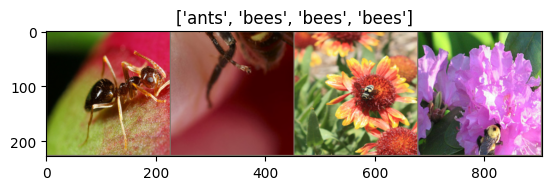

In [5]:
def imshow(inp, title=None):
    """tensor를 입력받아 일반적인 이미지로 보여줍니다."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### **방법 1 : 전체 finetuning**

In [8]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, ``nn.Linear(num_ftrs, len (class_names))`` 로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 68.4MB/s]


In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5343 Acc: 0.7254
val Loss: 0.4621 Acc: 0.8431

Epoch 1/24
----------
train Loss: 0.5246 Acc: 0.7951
val Loss: 0.2418 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.5309 Acc: 0.7869
val Loss: 0.7688 Acc: 0.7516

Epoch 3/24
----------
train Loss: 0.8158 Acc: 0.7541
val Loss: 0.5029 Acc: 0.8170

Epoch 4/24
----------
train Loss: 0.6839 Acc: 0.7787
val Loss: 0.5199 Acc: 0.8235

Epoch 5/24
----------
train Loss: 0.5532 Acc: 0.7787
val Loss: 0.4358 Acc: 0.8693

Epoch 6/24
----------
train Loss: 0.3970 Acc: 0.8320
val Loss: 0.3595 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.3207 Acc: 0.8648
val Loss: 0.3233 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.3061 Acc: 0.9098
val Loss: 0.2935 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.3927 Acc: 0.8320
val Loss: 0.2427 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.2134 Acc: 0.9180
val Loss: 0.2485 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.3277 Acc: 0.8730
val Loss: 0.2495 Acc: 0.9085

Ep

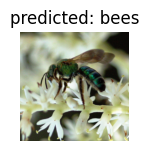

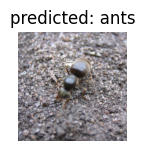

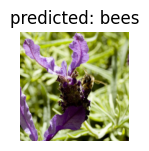

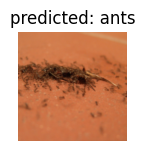

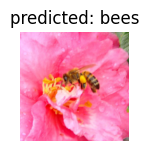

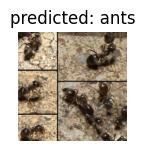

In [11]:
visualize_model(model_ft)

### **방법 2 : 신경망 feature 추출기 고정**

In [12]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True 임
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이전과는 다르게 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [13]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6965 Acc: 0.6475
val Loss: 0.3897 Acc: 0.8562

Epoch 1/24
----------
train Loss: 0.6718 Acc: 0.6844
val Loss: 0.2065 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4386 Acc: 0.8074
val Loss: 0.2219 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.4730 Acc: 0.7951
val Loss: 0.1632 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.4654 Acc: 0.8074
val Loss: 0.1796 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.5004 Acc: 0.7951
val Loss: 0.2512 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.4396 Acc: 0.8197
val Loss: 0.2460 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.3070 Acc: 0.8607
val Loss: 0.1913 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.2419 Acc: 0.9057
val Loss: 0.1963 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3553 Acc: 0.8320
val Loss: 0.1991 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3531 Acc: 0.8648
val Loss: 0.1739 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3205 Acc: 0.8484
val Loss: 0.2229 Acc: 0.9346

Ep

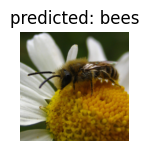

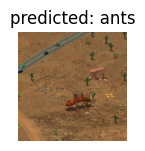

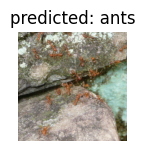

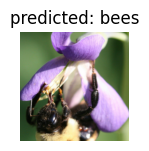

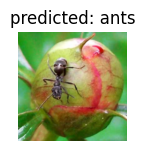

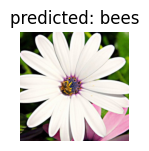

In [15]:
visualize_model(model_conv)

plt.ioff()
plt.show()